# Weekly Stock Charts
This notebook will go through training a model that will attempt to predict the stock movements given a **weekly** candlestick plot of the same stock in the past few months. The look-forward timeline will be about a month, and the cutoff will be ten percent. The inspiration to use weekly stock charts come from William O'Neil's excellent books [_How to Make Money in Stocks_](https://a.co/d/gCEQYOC) and [_24 Essential Lessons for Investment Success_](https://a.co/d/7LUhxW8). Although these books released at the turn of the century, the lessons still hold true today. In particular, the author outlines several important points when buying and selling stocks, and a vast majority of the examples use weekly candlestick plots as a reference. If past analysis was able to discover various patterns, then a deep learning model for image recognition should reflect the same predictive power. 

Admittedly, the time frame for when to check stock jumps is a bit arbitrary, as it heavily varies in the real-world. The look-forward cutoff will most likely need to be tuned, both in the amount of time, and the percentage change. Let's get started!

## Introduction
The data we will use comes from a proprietary source that gives minute-by-minute data of a wide range of stocks. In our use case, we'll focus on stocks listed in the NASDAQ 100. To produce our candlestick plots, we'll use the `mplfinance` package, and they will outputted to files. Since these candlestick plots are images, we'll use a pre-trained model that will be fine-tuned. Hopefully, at the end of our model training, we will get an accuracy of above 50%, which indicates _something_ has been discovered as a possible pattern.

## Import Packages
As usual, we'll start with importing all the packages we'll need. As mentioned in the introduction, the package of note is the `mplfinance` package, which can plot our candlestick plots without hassle, as well as do other financial analysis. Additionally, using `multiprocessing` will become very important when we generate the plots, as it does not take a trivial amount of time to generate a single plot.

In [18]:
import io
import os
import glob
import datetime as dt
from typing import Optional
import multiprocessing as mp

import numpy as np
import pandas as pd
from tqdm import tqdm

import mplfinance as mpf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import cv2
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import pytorch_lightning as pl
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS

ROOT = '../'
DATA_DIR = os.path.join(ROOT, 'data', 'NASDAQ 100 Index Components')
MINUTE_TXT_DIR = os.path.join(DATA_DIR, 'minute_txt_files')
VAL_SPLIT_DATE = dt.datetime(2015, 1, 1)  # Everything after this date will be treated as validation

## Data Description
As stated before, the data I will be preprocessing from is a proprietary data source I bought from back in 2018. It is essentially minute-by-minute stock data for all the stocks in the exchange. They are broken down into separate groups, such as index funds, regular stocks, NASDAQ 100, and the S & P 500. In our case, we will be dealing with the stocks in the **NASDAQ 100**. 

Because this goes as far back in time as possible, there won't be exactly 100 stocks in the NASDAQ 100 group. This is because different stocks enter and leave over time. The files themselves are TXT files. Let's examine one of these stocks: **AAPL**.

In [2]:
# Although they are .txt files, we can still use read_csv.
# Sort by the date, then the time.
aapl = pd.read_csv(os.path.join(MINUTE_TXT_DIR, 'AAPL.txt'), parse_dates=[0]).sort_values(by=['Date', 'Time'])
aapl.head()

,Date,Time,Open,High,Low,Close,Volume
0,2002-12-30,930,0.93,0.93,0.93,0.93,571466
1,2002-12-30,931,0.93,0.93,0.93,0.93,170800
2,2002-12-30,932,0.93,0.93,0.93,0.93,110320
3,2002-12-30,933,0.93,0.93,0.93,0.93,28000
4,2002-12-30,934,0.93,0.93,0.93,0.93,123900


We have 7 columns:
- **Date** - The actual date.
- **Time** - Since this is minute data, we need the exact minute. It is displayed as a concatenated number.
- **Open** - The _open_ price is the price of the stock at the start of the minute.
- **High** - The highest price this stock was during the minute.
- **Low** - The lowest price this stock was during the minute.
- **Close** - The price of the stock at the end of the minute.
- **Volume** - The number of shares that were traded during this minute.

These variable definitions _do not_ depend on the time frequency of the data. Whether it's minute, daily, or weekly, the open, high, low, close, and volume mean the same. This means that we can preprocess in a straightforward manner.

## Preprocessing
Going from a minute frequency to a weekly frequency is easy. The `Time` column will be eliminated, and the `Date` column will now show the date of the start of the week. Ordinarily, no trades happen on the weekends. There are holidays throughout the year, but there is no reason to expand or shorten the week depending on the presence of a holiday. Each week in our data will start on the Monday and end on the Friday.

The open and close prices will be what the prices were at the start and end of the week respectively. Likewise, the high and low prices will be for the highest and lowest price points during the week. With volume, we sum the volume for each minute in the week and get the total volume for the week.

**We want to get the first full week of data, namely the first Monday.** This ensures each week is consistent as possible. This might not apply to the last week in the data though.

In [3]:
# .weekday() gets the day of the week.
# 0 = Monday, 6 = Sunday
# Find the first Monday in the dataset...
i = 0
while i < len(aapl):
    if aapl['Date'].iloc[i].weekday() == 0:
        break
    i += 1

aapl = aapl.iloc[i:]

# Now it starts with a Monday, we need to record the week each day 
# is part of. For each date, we subtract off the weekday integer.
aapl['Week'] = aapl['Date'] - pd.to_timedelta(aapl['Date'].dt.weekday, unit='d')
aapl.drop(columns='Date', inplace=True)
aapl.head()

,Time,Open,High,Low,Close,Volume,Week
0,930,0.93,0.93,0.93,0.93,571466,2002-12-30
1,931,0.93,0.93,0.93,0.93,170800,2002-12-30
2,932,0.93,0.93,0.93,0.93,110320,2002-12-30
3,933,0.93,0.93,0.93,0.93,28000,2002-12-30
4,934,0.93,0.93,0.93,0.93,123900,2002-12-30


Now that we what each week each row is from, we can easily aggregate the data using `.groupby()`. Remember, we need the **minimum** low price, the **maximum** high price, and the **sum** of the volume. For open and close, we need the first and last rows for each week.

In [4]:
groups = aapl.groupby('Week')

# groupby automatically sorts by the Week.
# groups.groups is a key-value dictionary of each group name and the 
# corresponding indices in the original df that it mapped to. 
# Using this, we can find the earliest and latest time point for each week,
# a.k.a our open and close prices.
open_indices = [min(groups.groups[key]) for key in sorted(groups.groups.keys())]
opens = aapl.iloc[open_indices]['Open'].values

close_indices = [max(groups.groups[key]) for key in sorted(groups.groups.keys())]
closes = aapl.iloc[close_indices]['Close'].values

highs = groups.max()['High'].values
lows = groups.min()['Low'].values
volumes = groups.sum()['Volume'].values

# Concatenate them all, and create a dataframe out of it...
processed = pd.DataFrame(data=np.vstack((opens, highs, lows, closes, volumes)).T,
                         index=np.unique(aapl['Week']), columns=['Open', 'High', 'Low', 'Close', 'Volume'])
processed['Volume'] = processed['Volume'].astype(int)
processed.head()

,Open,High,Low,Close,Volume
2002-12-30,0.93,0.97,0.92,0.97,157277204
2003-01-06,0.98,1.00,0.96,0.97,313492984
2003-01-13,0.97,0.97,0.93,0.93,367800566
2003-01-20,0.94,0.95,0.91,0.92,235185202
2003-01-27,0.91,0.98,0.91,0.95,420238056


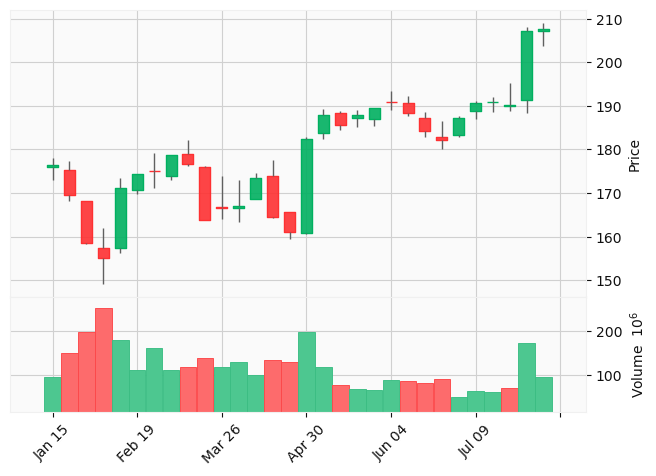

In [6]:
LOOKBACK_WEEKS = 30
data = processed.iloc[-LOOKBACK_WEEKS:, :]
mpf.plot(data, type='candle', style='yahoo', volume=True)

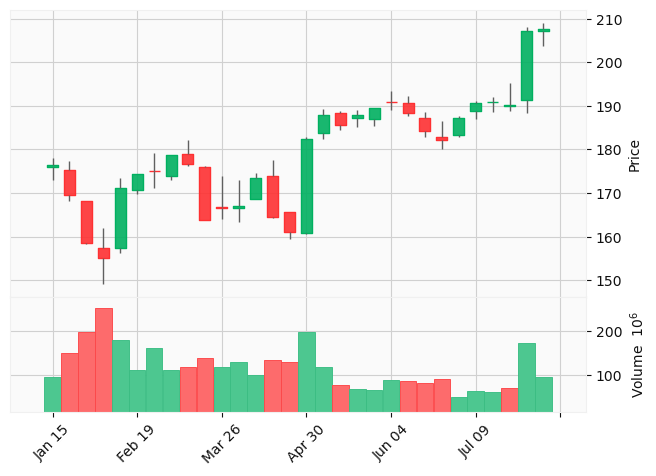

In [7]:
fig, ax = mpf.plot(data, type='candle', style='yahoo', volume=True, returnfig=True)

In [8]:
canvas = fig.canvas

In [9]:
canvas.draw()

In [10]:
width, height = canvas.get_width_height()

In [11]:
image_array = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
image_array = image_array.reshape(height, width, 3)

C:\Users\mughi\AppData\Local\Temp\ipykernel_17084\2627200568.py:1: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_array = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')


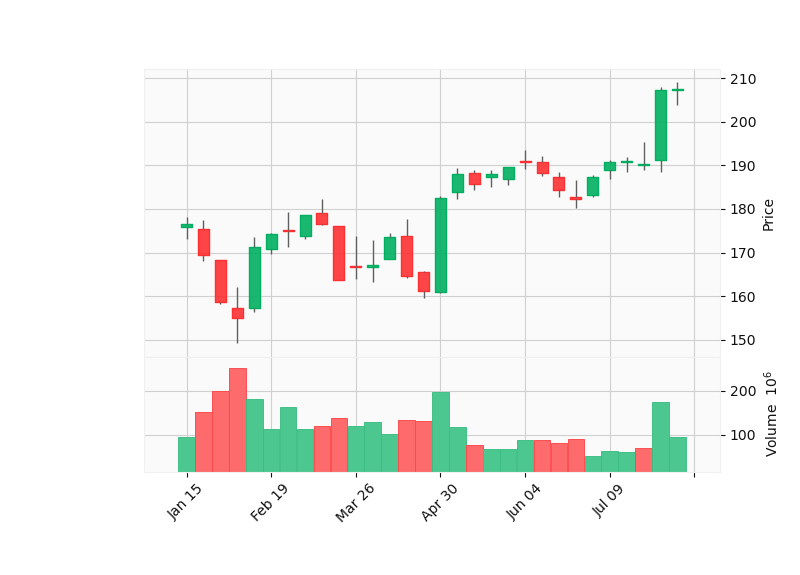

In [14]:
Image.fromarray(image_array)

In [36]:
plotly_fig = go.Figure(data=[go.Candlestick(x=data.index,
                                            open=data['Open'],
                                            high=data['High'],
                                            low=data['Low'],
                                            close=data['Close'])])
plotly_fig.update_layout(xaxis_rangeslider_visible=False)
plotly_fig.show()

In [46]:
plotly_fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7, 0.3])

# Plot candles in the first plot
plotly_fig.add_trace(go.Candlestick(x=data.index, open=data['Open'], high=data['High'], low=data['Low'], close=data['Close'],
                                    name='price', increasing_line_color='#26a69a', decreasing_line_color='#ef5350', showlegend=False), row=1, col=1)
# Extract the green volume and red volume separately
green_volume_df = data[data['Close'] > data['Open']]
red_volume_df = data[data['Open'] > data['Close']]

# Add two separate traces for each one...
plotly_fig.add_trace(go.Bar(x=red_volume_df.index, y=red_volume_df['Volume'], showlegend=False, marker_color='#ef5350'), row=2, col=1)
plotly_fig.add_trace(go.Bar(x=green_volume_df.index, y=green_volume_df['Volume'], showlegend=False, marker_color='#26a69a'), row=2, col=1)

# Hide the range slider
plotly_fig.update_layout(xaxis_rangeslider_visible=False, yaxis_title='Price')
plotly_fig.update_yaxes(title_text='Volume', row=2, col=1)

plotly_fig.show()

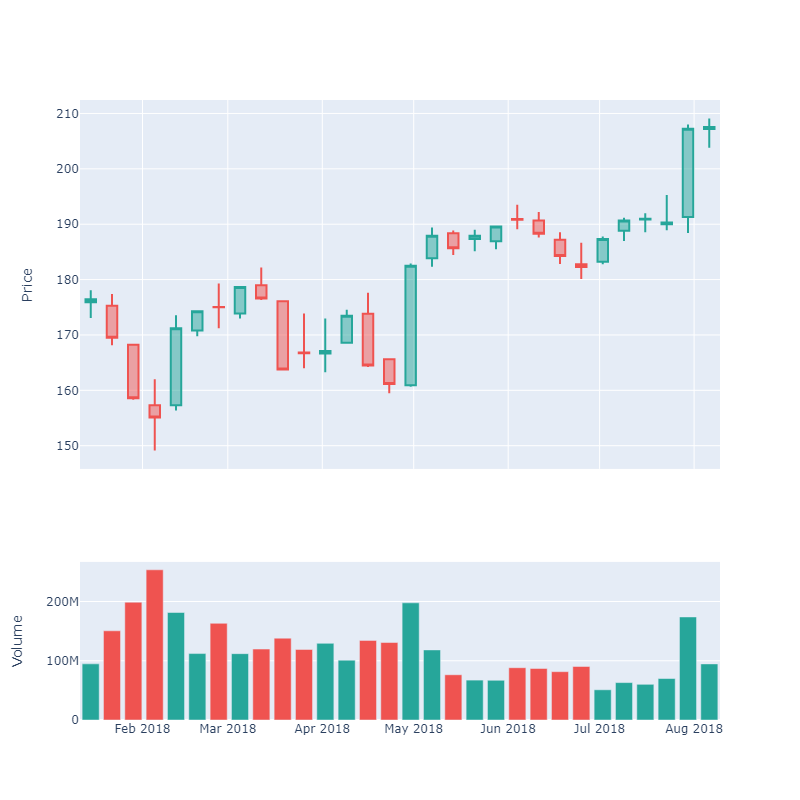

In [47]:
img_bytes = plotly_fig.to_image(format='png', width=800, height=800)
buf = io.BytesIO(img_bytes)
image = Image.open(buf)
image


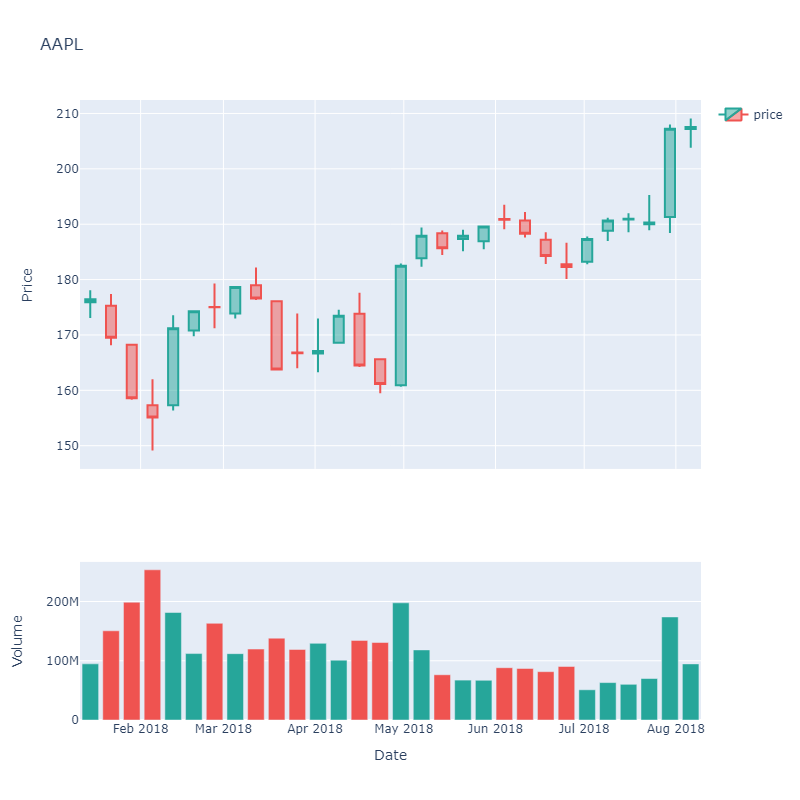

In [34]:
image

In [49]:
# Next, it's time to decide how to make the labels. We have to be
# careful in this one, because the quality of the label will determine 
# how well the model can perform. 
processed

,Open,High,Low,Close,Volume
2002-12-30,0.93,0.97,0.92,0.97,157277204
2003-01-06,0.98,1.00,0.96,0.97,313492984
2003-01-13,0.97,0.97,0.93,0.93,367800566
2003-01-20,0.94,0.95,0.91,0.92,235185202
2003-01-27,0.91,0.98,0.91,0.95,420238056
...,...,...,...,...,...
2018-07-09,188.84,191.17,186.95,190.66,63146880
2018-07-16,190.85,191.98,188.54,191.00,60232773
2018-07-23,190.00,195.28,188.90,190.31,69987342
2018-07-30,191.31,208.01,188.41,207.25,173943077


In [53]:
processed.index[LOOKBACK_WEEKS - 1: ]

DatetimeIndex(['2003-07-21', '2003-07-28', '2003-08-04', '2003-08-11',
               '2003-08-18', '2003-08-25', '2003-09-01', '2003-09-08',
               '2003-09-15', '2003-09-22',
               ...
               '2018-06-04', '2018-06-11', '2018-06-18', '2018-06-25',
               '2018-07-02', '2018-07-09', '2018-07-16', '2018-07-23',
               '2018-07-30', '2018-08-06'],
              dtype='datetime64[ns]', length=786, freq=None)

In [54]:
processed.loc[dt.datetime(2003, 7, 21) - dt.timedelta(weeks=LOOKBACK_WEEKS): dt.datetime(2003, 7, 21)]

,Open,High,Low,Close,Volume
2002-12-30,0.93,0.97,0.92,0.97,157277204
2003-01-06,0.98,1.00,0.96,0.97,313492984
2003-01-13,0.97,0.97,0.93,0.93,367800566
2003-01-20,0.94,0.95,0.91,0.92,235185202
2003-01-27,0.91,0.98,0.91,0.95,420238056
2003-02-03,0.95,0.97,0.93,0.94,287092848
2003-02-10,0.94,0.97,0.93,0.97,222279848
2003-02-17,0.97,1.00,0.97,0.97,201290670
2003-02-24,0.97,0.98,0.96,0.97,210578396
2003-03-03,0.98,0.99,0.95,0.96,163657802


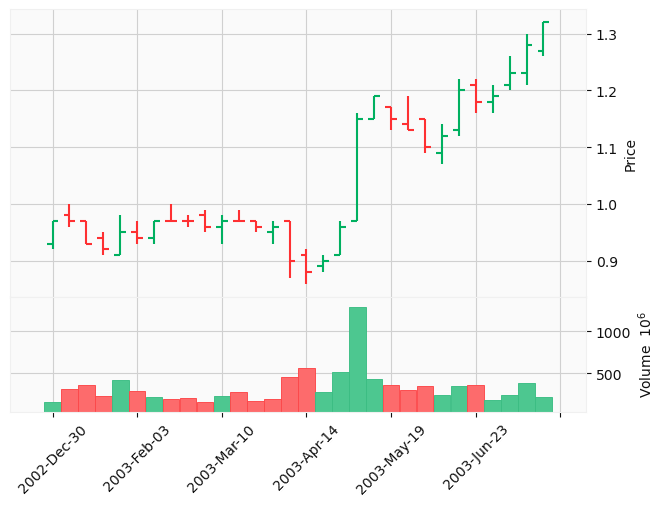

In [58]:
mpf.plot(processed.loc[dt.datetime(2003, 7, 21) - dt.timedelta(weeks=LOOKBACK_WEEKS): dt.datetime(2003, 7, 21)], style='yahoo', volume=True)

In [56]:
processed.loc[dt.datetime(2003, 7, 21) : dt.datetime(2003, 7, 21) + dt.timedelta(weeks=10)]

,Open,High,Low,Close,Volume
2003-07-21,1.27,1.32,1.26,1.32,225543906
2003-07-28,1.32,1.32,1.25,1.27,220971044
2003-08-04,1.27,1.32,1.21,1.22,227907050
2003-08-11,1.22,1.26,1.21,1.23,204294230
2003-08-18,1.23,1.35,1.23,1.28,259639366
2003-08-25,1.28,1.40,1.26,1.38,261031134
2003-09-01,1.39,1.43,1.37,1.38,222888722
2003-09-08,1.38,1.42,1.36,1.42,226652062
2003-09-15,1.40,1.41,1.34,1.37,287445018
2003-09-22,1.37,1.38,1.24,1.27,367660286


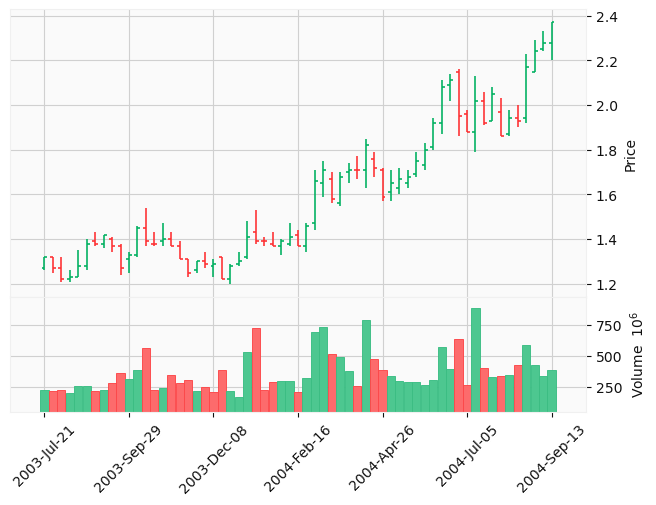

In [61]:
mpf.plot(processed.loc[dt.datetime(2003, 7, 21) : dt.datetime(2003, 7, 21) + dt.timedelta(weeks=60)], style='yahoo', volume=True)

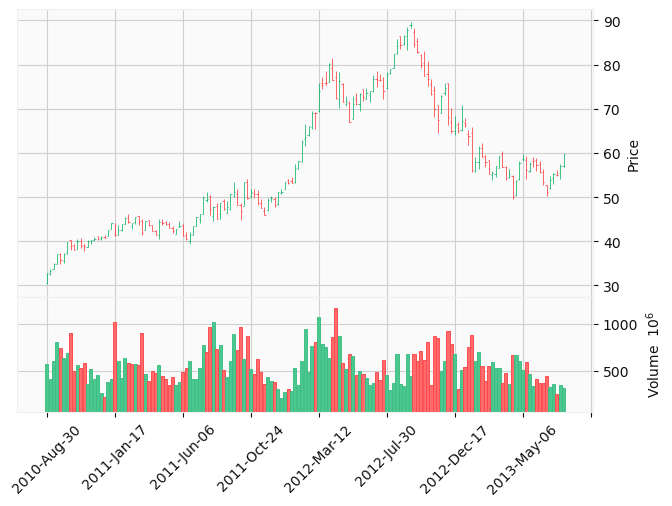

In [66]:
mpf.plot(processed.loc['2010-08-30': '2013-07-30'], style='yahoo', volume=True)

In [ ]:
# Check 30% increase WITHIN 6 months of the buy point, WITHOUT having more than an 8% loss from the buy point.
# If it is, then BUY, otherwise DON'T BUY. 
# We'll see how this goes.